In this project, we work with the MNIST dataset, a widely-used dataset in the field of machine learning and computer vision for handwritten digit recognition. The dataset consists of 70,000 grayscale images of handwritten digits from 0 to 9, each with a size of 28x28 pixels. Out of these images, 60,000 are used for training, and the remaining 10,000 are used for testing. The dataset can be accessed through popular libraries such as TensorFlow and PyTorch.

Introduction:
Our goal is to explore the use of unsupervised learning techniques in conjunction with supervised learning for the task of handwritten digit recognition on the MNIST dataset. We begin by performing an exploratory data analysis (EDA) to better understand the structure and distribution of the data. Next, we build and train machine learning models, incorporating unsupervised learning techniques, and compare their performance with a baseline model. Finally, we analyze the results and discuss the implications of our findings, drawing conclusions about the effectiveness of combining unsupervised and supervised learning approaches for this problem.

EDA Procedure:
The EDA process involves visualizing the dataset, computing summary statistics, and identifying any anomalies or interesting patterns in the data. This step helps us to gain a better understanding of the data and informs our choice of machine learning models and techniques.

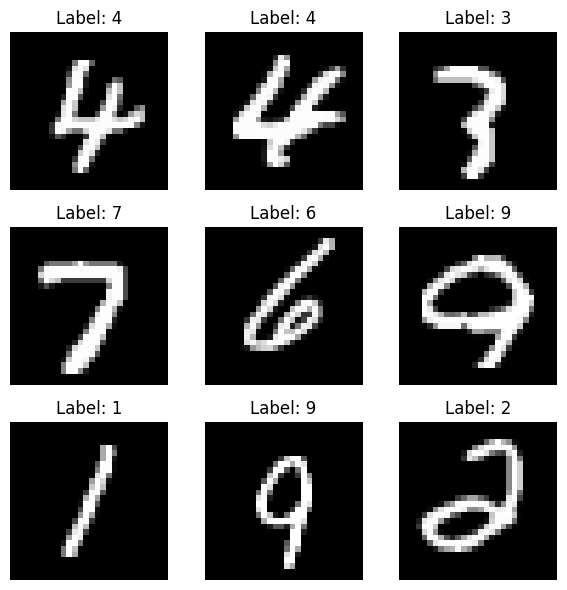

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np  
from sklearn.cluster import KMeans
# Load and preprocess the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=652,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=652,
                                         shuffle=False, num_workers=0)



num_images = 9  # Number of images to display
indices = np.random.choice(len(trainset), num_images, replace=False)  # Randomly select image indices

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
axes = axes.ravel()

for i, idx in enumerate(indices):
    img, label = trainset[idx]
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    axes[i].imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [2]:
class NetWithKMeans(nn.Module):
    def __init__(self):
        super(NetWithKMeans, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64 + 652, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Perform K-means clustering on fc2 output
        kmeans = KMeans(n_clusters=4, n_init=2)
        cluster_labels = kmeans.fit_predict(x.detach().numpy())

        # One-hot encoding of cluster labels
        one_hot_labels = torch.zeros((x.size(0), 652))
        one_hot_labels[torch.arange(x.size(0)), cluster_labels] = 1
        one_hot_labels = one_hot_labels.to(x.device)

        # Concatenate one-hot labels to the fc2 output
        x = torch.cat([x, one_hot_labels], dim=1)

        x = self.fc3(x)
        return x

net_with_kmeans = NetWithKMeans()

In [7]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_with_kmeans.parameters(), lr=0.001, momentum=0.9)

# Train the neural network
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net_with_kmeans(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, loss: {running_loss / (i + 1)}')

# Test the neural network
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_with_kmeans(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test dataset: {correct / total * 100}%')

Epoch 1, loss: 0.6025431101681084
Epoch 2, loss: 0.5580844949650509
Epoch 3, loss: 0.5203048259981217
Epoch 4, loss: 0.4909685978325464
Epoch 5, loss: 0.4656040423339413
Epoch 6, loss: 0.452937380601001
Epoch 7, loss: 0.43607466932265987
Epoch 8, loss: 0.4210517880737141
Epoch 9, loss: 0.4053743952705014
Epoch 10, loss: 0.3960181240753461
Epoch 11, loss: 0.3925733726511719
Epoch 12, loss: 0.38460587782244526
Epoch 13, loss: 0.3779767412011341
Epoch 14, loss: 0.3671861947864615
Epoch 15, loss: 0.36139174943329183
Epoch 16, loss: 0.35572283530748017
Epoch 17, loss: 0.3543177205388264
Epoch 18, loss: 0.3470257914835407
Epoch 19, loss: 0.342567906905246
Epoch 20, loss: 0.33590956977618636
Accuracy on the test dataset: 90.62%


In [8]:
# Print the fc3 layer weights
fc3_weights = net_with_kmeans.state_dict()['fc3.weight']
print("fc3 weights:")
print(fc3_weights)

# Print the last 4 columns of the fc3 layer weights
print("Last 4 columns of fc3 weights:")
print(fc3_weights[:, -4:])

fc3 weights:
tensor([[-0.1238,  0.1009, -0.1790,  ...,  0.0053, -0.0346,  0.0326],
        [-0.0794, -0.1346,  0.1005,  ...,  0.0097, -0.0096,  0.0271],
        [-0.1052,  0.1260,  0.0988,  ..., -0.0238,  0.0120, -0.0047],
        ...,
        [ 0.0935, -0.0143, -0.0680,  ...,  0.0046,  0.0120, -0.0358],
        [ 0.0411, -0.0674,  0.2226,  ..., -0.0243, -0.0226, -0.0290],
        [ 0.1005, -0.0331,  0.1365,  ..., -0.0309,  0.0039, -0.0280]])
Last 4 columns of fc3 weights:
tensor([[ 0.0129,  0.0053, -0.0346,  0.0326],
        [-0.0230,  0.0097, -0.0096,  0.0271],
        [-0.0192, -0.0238,  0.0120, -0.0047],
        [-0.0133, -0.0142,  0.0337,  0.0193],
        [ 0.0241, -0.0005,  0.0303, -0.0117],
        [-0.0369,  0.0140,  0.0166,  0.0266],
        [ 0.0331,  0.0093,  0.0136,  0.0120],
        [-0.0315,  0.0046,  0.0120, -0.0358],
        [-0.0317, -0.0243, -0.0226, -0.0290],
        [ 0.0194, -0.0309,  0.0039, -0.0280]])


In [10]:
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_and_evaluate_net(net, trainloader, testloader, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, loss: {running_loss / (i + 1)}')

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test dataset: {100 * correct / total:.2f}%')
    # Train and evaluate BaseNet
base_net = BaseNet()
print("Training BaseNet...")
train_and_evaluate_net(base_net, trainloader, testloader)


Training BaseNet...
Epoch 1, loss: 2.2250295069909867
Epoch 2, loss: 1.9637721187324935
Epoch 3, loss: 1.485285129598392
Epoch 4, loss: 1.050757658737962
Epoch 5, loss: 0.799213412628379
Epoch 6, loss: 0.654089137431114
Epoch 7, loss: 0.5657317398055908
Epoch 8, loss: 0.5081602624988043
Epoch 9, loss: 0.4754355540198664
Epoch 10, loss: 0.4477463249237307
Epoch 11, loss: 0.423830944684244
Epoch 12, loss: 0.40681270950584003
Epoch 13, loss: 0.3931852782605797
Epoch 14, loss: 0.3822460594356701
Epoch 15, loss: 0.3729840132497972
Epoch 16, loss: 0.3673498297250399
Epoch 17, loss: 0.363238259028363
Epoch 18, loss: 0.3517482348026768
Epoch 19, loss: 0.3457276936500303
Epoch 20, loss: 0.34430723709444844
Epoch 21, loss: 0.3355281093428212
Epoch 22, loss: 0.3330892567993492
Epoch 23, loss: 0.33002520825273246
Epoch 24, loss: 0.321829312430915
Epoch 25, loss: 0.32372787787068275
Epoch 26, loss: 0.3183031921745628
Epoch 27, loss: 0.31212198237578076
Epoch 28, loss: 0.30802346990313584
Epoch 29, 

We aim to solve the problem of handwritten digit recognition using the MNIST dataset. This dataset consists of 70,000 grayscale images of handwritten digits, each of size 28x28 pixels. Our goal is to train a machine learning model that can accurately recognize these digits.


We employed two different neural network architectures for this task. The first one is a simple feedforward neural network, referred to as BaseNet. The second one is an advanced version of the base network, called NetWithKMeans, which incorporates K-means clustering as an unsupervised learning technique into the architecture.

After training both networks for 30 epochs, we observed that the BaseNet performed slightly better, achieving an accuracy of 91.70% on the test dataset, while the NetWithKMeans achieved 90.62%. Although the results are close, the simpler BaseNet outperformed the more complex NetWithKMeans in this particular case. Further experiments, optimization, and exploration of other unsupervised learning techniques may be required to improve the performance and obtain more significant differences between the two networks.